In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
from copy import deepcopy as dc
import random
from skimage import measure
import geometry_bspline as bsp_geom
import NeuralImplicit as NI
import geometry_visualisation as geom_vis
import geometry_definitions as geom_defs
torch.set_default_dtype(torch.float64)

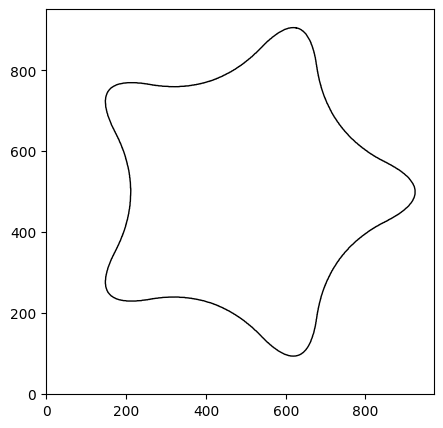

In [5]:
N = 1000                         # grid resolution
x_vals = np.linspace(-1, 1, N)
y_vals = np.linspace(-1, 1, N)
X, Y = np.meshgrid(x_vals, y_vals)

pts = np.stack([X.ravel(), Y.ravel()], axis=1)
pts_t = torch.tensor(pts, dtype=torch.float64)

with torch.no_grad():
    #Z = model(pts_t).cpu().numpy().reshape(N, N)
    rounded_star_cp = geom_defs.create_star_bspline_control_points(center=(0, 0), outer_radius=1.0, inner_radius=0.5, num_star_points=5, degree=2)
    #L_shape = bsp_geom.create_L_shape_bspline_control_points(1)
    Z = bsp_geom.bspline_signed_distance_vectorized(pts_t, rounded_star_cp, degree=2, use_refinment=False).numpy().reshape(N, N)
contours = measure.find_contours(Z, level=0.0)
plt.figure(figsize=(5, 5))
plt.contourf(X, Y, Z, levels=50, cmap='RdBu_r')
for contour in contours:
    plt.plot(contour[:, 1] , contour[:,0] , 'k-', linewidth=1)
plt.show()

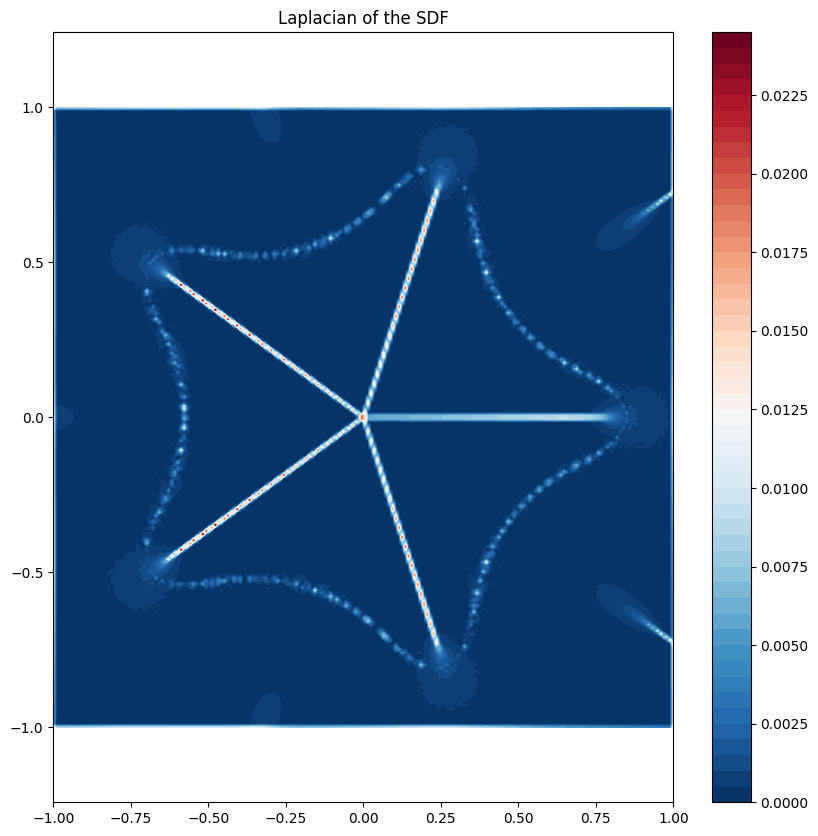

In [6]:
geom_vis.plot_laplacian_of_bspline_sdf()

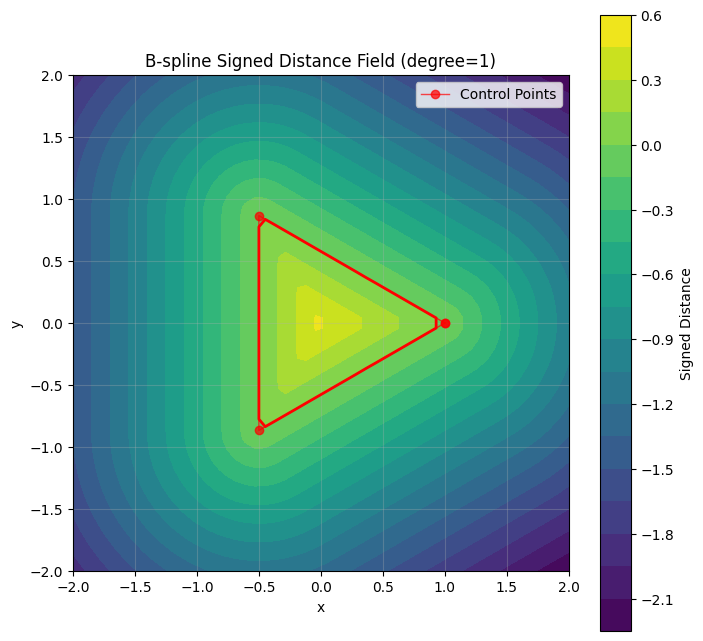

In [3]:
ctrl_pts = bsp_geom.create_star_bspline_control_points(center=(0, 0), outer_radius=1.0, inner_radius=0.5, num_star_points=5, degree=1)
ctrl_pts = bsp_geom.create_polygon_bspline_control_points(num_vertices=3, degree=1)
bsp_geom.plot_bspline_distance_field(ctrl_pts, degree=1, N=50)

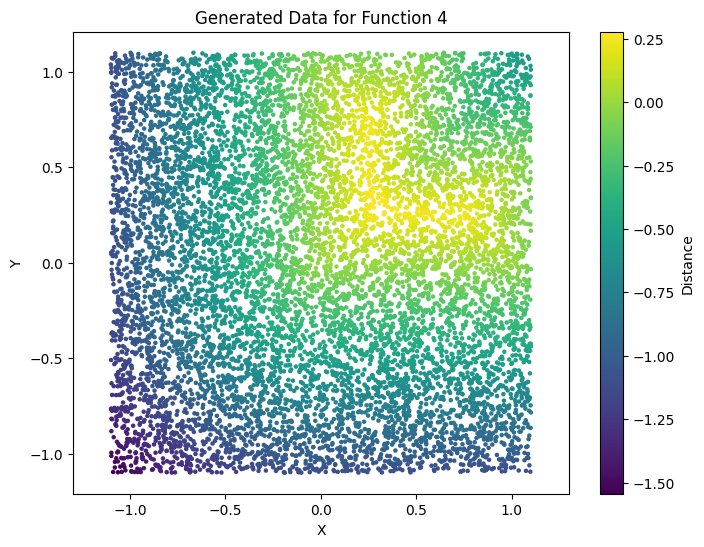

In [ ]:
def plot_generated_data(fun_num, num_samples=5000, data_gen_params={}):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    coordinates, distances = NI.generate_bspline_data(num_samples,fun_num, device=device, data_gen_params=data_gen_params)
    coordinates = coordinates.cpu().numpy()
    distances = distances.cpu().numpy()

    plt.figure(figsize=(6, 4))
    sc = plt.scatter(coordinates[:, 0], coordinates[:, 1], c=distances[:, 0], cmap='viridis', s=5)
    plt.colorbar(sc, label='Distance')
    plt.title(f'Generated Data for Function {fun_num}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis('equal')
    plt.show()
plot_generated_data(fun_num=4, num_samples=10000, data_gen_params={"num_vertices":3})

In [ ]:
NI.plot_model_weight_per_layer_hyst(model)

In [ ]:
def train_model(model,num_epochs=10):
    report_interval = num_epochs // 10
    criterion = nn.MSELoss()
    star_cp = bsp_geom.create_star_bspline_control_points(center=(0, 0), outer_radius=1.0, inner_radius=0.5, num_star_points=5, degree=1)
    knots = bsp_geom.create_knot_vector(len(star_cp), degree=1)
    L_EIKON = 1e3
    L_BND = 1e4
    L_BND_GRAD = 1e1
    L_XI = 3e2
    NUM_POINTS = 1000
    for epoch in range(num_epochs):
        star_cp = bsp_geom.create_star_bspline_control_points(center=(0, 0), outer_radius=1.0, inner_radius=0.5, num_star_points=5, degree=1)
        boundary_pts, t_values = bsp_geom.generate_points_on_curve(star_cp, num_points=NUM_POINTS, degree=1, device=None, return_t=True)
        other_pts = torch.randn((NUM_POINTS,2))*2-1
        other_pts = other_pts.clone().detach().requires_grad_(True)
        pred_other = model(other_pts)
        grds = torch.autograd.grad(outputs=pred_other, inputs=other_pts, grad_outputs=torch.ones_like(pred_other),retain_graph=True, allow_unused=True, create_graph=True)
        eikonloss = torch.sum(grds[0]**2,dim=1)
        eikonloss_output = torch.abs(1-torch.sqrt(eikonloss)).mean()
        boundary_pts = boundary_pts.clone().detach().requires_grad_(True)
        bond_normal = bsp_geom.bspline_normalvectors(t_values,star_cp,knots,degree=1)
        # elementwise scalar product of bond_normal and gradient of pred_boundary
        pred_boundary = model(boundary_pts)
        grds_boundary = torch.autograd.grad(outputs=pred_boundary, inputs=boundary_pts, grad_outputs=torch.ones_like(pred_boundary),retain_graph=True, allow_unused=True, create_graph=True)
        #print(grds_boundary)
        scalar_prods = torch.sum(grds_boundary[0] * bond_normal, dim=1)
        scalar_loss = torch.abs(1- scalar_prods).mean()
        loss_boundary = torch.abs(torch.mean(torch.abs(pred_boundary)))
        loss_xi = torch.mean(torch.exp(-100*torch.abs(pred_other)))
        loss = L_BND*loss_boundary + L_EIKON*eikonloss_output + L_XI*loss_xi + L_BND_GRAD*scalar_loss
        model.optimizer.zero_grad()
        loss.backward()
        model.optimizer.step()
        model.lr_scheduler.step()
        model.loss_history.append(loss.item())
        if epoch % report_interval == 0:
            CALCULATE_ERROR = False
            if CALCULATE_ERROR:
                pts = torch.randn((5000,2))*2-1
                with torch.no_grad():
                    pred = model(pts)
                    star_sdf = bsp_geom.bspline_signed_distance_vectorized(pts,star_cp,degree=1)
                    error = criterion(pred.squeeze(), star_sdf)
                print(f"Epoch {epoch}, Loss: {loss.item():.6f}, SDF Error: {error.item():.6f}")
                print(f"Losses: Boundary: {L_BND*loss_boundary.item():.6f}, Eikonal: {L_EIKON*eikonloss_output.item():.6f}, Xi: {L_XI*loss_xi.item():.6f}, Scalar prod: {L_BND_GRAD*scalar_loss.item():.6f}")
            else:
                print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
            
train_model(model,100)

In [2]:

architecture = [2,256,256,256,1]
model = NI.Siren(architecture, outermost_linear=True, first_omega_0=60, hidden_omega_0=60)
#model = NI.PE_Relu(architecture=[2,256,256,256,256,1], num_freqs=5)
#model = NI.NeuralNetwork(architecture=[2,256,256,256,256,1])
print(f"number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

model.optimizer = torch.optim.Adam(lr=1e-5, params=model.parameters())


#model.lr_scheduler = torch.optim.lr_scheduler.StepLR(model.optimizer, step_size=1000, gamma=0.8)

model.lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(model.optimizer, T_max=80000, eta_min=1e-6)

# SIREN 198k parameters - Adam - 1e-6 
# ReLU 189k parameters - Adam - 1e-6

number of parameters: 198401


In [3]:

NI.train_models_with_extras([model],num_epochs = 50000, batch_size = 200, fun_num=3, eikon_coeff=0.0, boundry_coeff=0,
                            data_gen_mode='bspline', use_scheduler = True,
                            crt = nn.L1Loss(),create_error_distribution_hystory=False,error_distribution_resolution=100, 
                            create_SDF_history=False, hytory_after_epochs=200)


Epoch [0], Losses: SIREN: 0.27685631289198553
Epoch [4999], Losses: SIREN: 0.005713875848829283
Epoch [9999], Losses: SIREN: 0.003910785967487601
Epoch [14999], Losses: SIREN: 0.0029425611412975316
Epoch [19999], Losses: SIREN: 0.0030929943510566277
Epoch [24999], Losses: SIREN: 0.002320987584853035
Epoch [29999], Losses: SIREN: 0.001953957182832576
Epoch [34999], Losses: SIREN: 0.0015722035815970833
Epoch [39999], Losses: SIREN: 0.0010680602684605403
Epoch [44999], Losses: SIREN: 0.000996697440034434
Epoch [49999], Losses: SIREN: 0.0008211889965829447


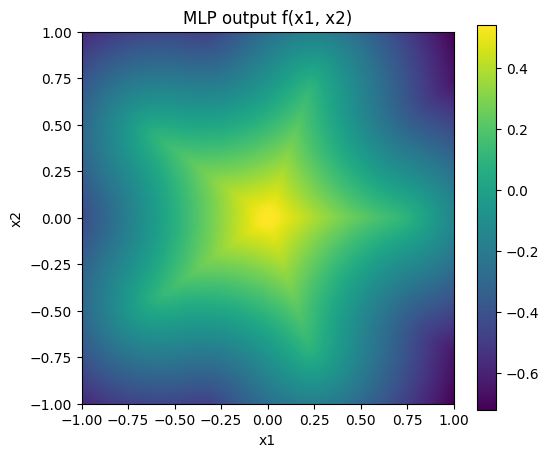

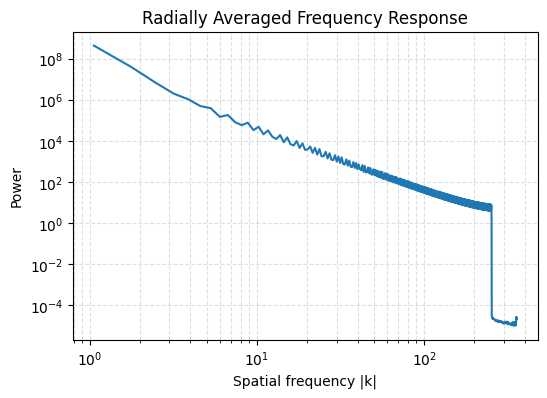

In [47]:
N = 1014                         # grid resolution
x_vals = np.linspace(-1, 1, N)
y_vals = np.linspace(-1, 1, N)
X, Y = np.meshgrid(x_vals, y_vals)

pts = np.stack([X.ravel(), Y.ravel()], axis=1)
pts_t = torch.tensor(pts, dtype=torch.float64)

with torch.no_grad():
    Z = model(pts_t).cpu().numpy().reshape(N, N)
    #rounded_star_cp = bsp_geom.create_star_bspline_control_points(center=(0, 0), outer_radius=1.0, inner_radius=0.5, num_star_points=5, degree=2)
    #L_shape = bsp_geom.create_L_shape_bspline_control_points(1)
    #Z = bsp_geom.bspline_signed_distance_vectorized(pts_t, rounded_star_cp, degree=2).numpy().reshape(N, N)
# ------------------------------------------------------------
# 3. Plot the output f(x)
# ------------------------------------------------------------
plt.figure(figsize=(6,5))
plt.imshow(Z, extent=[-1,1,-1,1], origin='lower')
plt.title("MLP output f(x1, x2)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.colorbar()
plt.show()

# ------------------------------------------------------------
# 4. Compute 2D FFT (frequency response)
# ------------------------------------------------------------
F = np.fft.fftshift(np.fft.fft2(Z))
power = np.abs(F)**2

# Frequency axes
freq_x = np.fft.fftshift(np.fft.fftfreq(N, d=(x_vals[1]-x_vals[0])))
freq_y = np.fft.fftshift(np.fft.fftfreq(N, d=(y_vals[1]-y_vals[0])))

FX, FY = np.meshgrid(freq_x, freq_y)
radial_freq = np.sqrt(FX**2 + FY**2).ravel()

# ------------------------------------------------------------
# 5. Radially averaged power spectrum
# ------------------------------------------------------------
nbins = N // 2
bins = np.linspace(0, radial_freq.max(), nbins+1)
radial_power = np.zeros(nbins)
counts = np.zeros(nbins)

bin_index = np.digitize(radial_freq, bins) - 1
flat_power = power.ravel()

for i, p in enumerate(flat_power):
    k = bin_index[i]
    if 0 <= k < nbins:
        radial_power[k] += p
        counts[k] += 1

radial_power /= np.maximum(1, counts)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# ------------------------------------------------------------
# 6. Plot frequency response
# ------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.loglog(bin_centers[1:], radial_power[1:])
plt.title("Radially Averaged Frequency Response")
plt.xlabel("Spatial frequency |k|")
plt.ylabel("Power")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.show()

MovieWriter imagemagick unavailable; using Pillow instead.


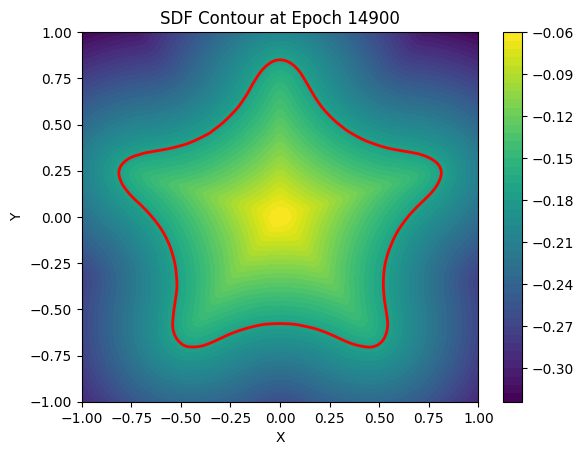

In [49]:
NI.create_animation_SDF_contourf(model, interval=500, save_path="SDF_evolution_ReLU_cos.gif", skip_initial_frames=0, adaptive_scaling=False, plot_cntr = True)

In [53]:
!ffmpeg -i error_anim_normal_sched_cos.gif -movflags faststart -pix_fmt yuv420p -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" error_anim_normal_sched_cos.mp4


ffmpeg version 8.0.1-full_build-www.gyan.dev Copyright (c) 2000-2025 the FFmpeg developers
  built with gcc 15.2.0 (Rev8, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-lcms2 --enable-libxml2 --enable-gmp --enable-bzlib --enable-lzma --enable-libsnappy --enable-zlib --enable-librist --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-libbluray --enable-libcaca --enable-libdvdnav --enable-libdvdread --enable-sdl2 --enable-libaribb24 --enable-libaribcaption --enable-libdav1d --enable-libdavs2 --enable-libopenjpeg --enable-libquirc --enable-libuavs3d --enable-libxevd --enable-libzvbi --enable-liboapv --enable-libqrencode --enable-librav1e --enable-libsvtav1 --enable-libvvenc --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs2 --enable-libxeve --enable-libxvid --enable-libaom --enable-libjxl --enable-libvpx --

MovieWriter imagemagick unavailable; using Pillow instead.


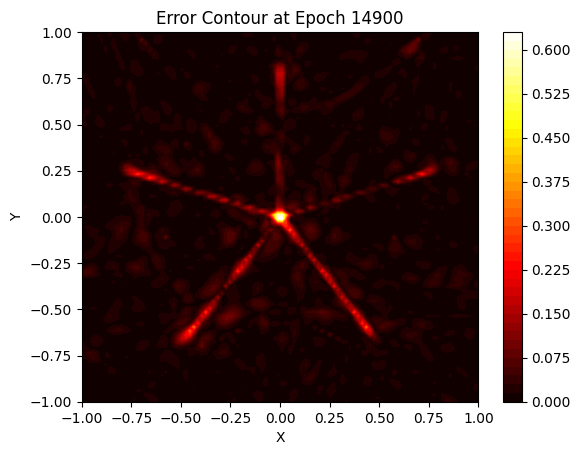

In [51]:
NI.create_animation_error_contourf(model, interval= 500,save_path="error_anim_ReLU_cos.gif",skip_initial_frames=0, adaptive_scaling=True, plot_cntr = False)

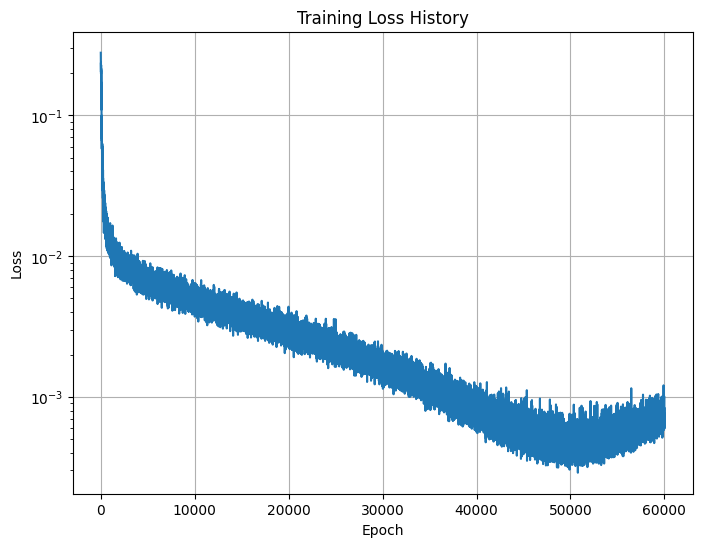

In [12]:
#plot loss history
plt.figure(figsize=(8, 6))
plt.plot(model.loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.grid(True)
plt.yscale('log')
plt.show()

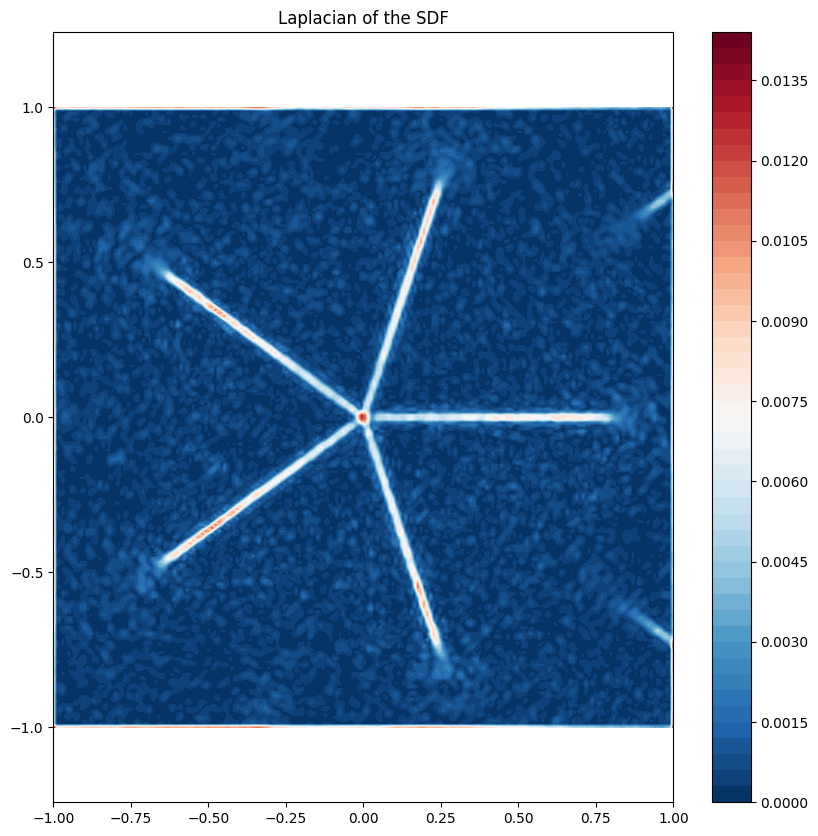

In [13]:
geom_vis.plot_laplacian_of_bspline_sdf(model=model)

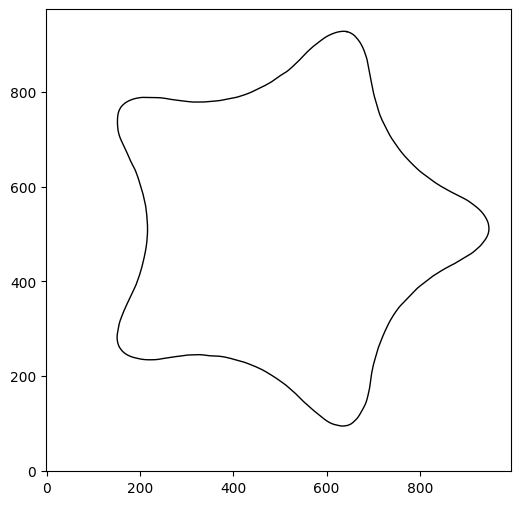

In [14]:
N = 1024                        # grid resolution
x_vals = np.linspace(-1, 1, N)
y_vals = np.linspace(-1, 1, N)
X, Y = np.meshgrid(x_vals, y_vals)

pts = np.stack([X.ravel(), Y.ravel()], axis=1)
pts_t = torch.tensor(pts, dtype=torch.float64)

with torch.no_grad():
    Z = model(pts_t).cpu().numpy().reshape(N, N)
    #rounded_star_cp = bsp_geom.create_star_bspline_control_points(center=(0, 0), outer_radius=1.0, inner_radius=0.5, num_star_points=5, degree=2)
    #L_shape = bsp_geom.create_L_shape_bspline_control_points(1)
    #Z = bsp_geom.bspline_signed_distance_vectorized(pts_t, rounded_star_cp, degree=2).numpy().reshape(N, N)
contours = measure.find_contours(Z, level=0.0)
# convert to [-1,1,-1,1]
contours_red = contours

fig, ax = plt.subplots(figsize=(6, 6))
ax.contourf(X, Y, Z, levels=50, cmap='RdBu_r')
for contour in contours:
    ax.plot(contour[:, 1] , contour[:,0] , 'k-', linewidth=1)
plt.show()

C:\Users\csapo\AppData\Local\Temp\ipykernel_18584\3835436375.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  contours_t = torch.tensor(contours, dtype=torch.float64).reshape(-1,2)


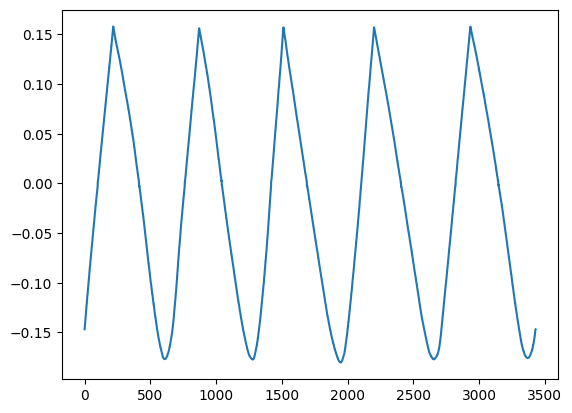

In [15]:
import geometry_definitions as geom_defs
rounded_star_cp = geom_defs.create_star_bspline_control_points(center=(0, 0), outer_radius=1.0, inner_radius=0.5, num_star_points=5, degree=2)
#convert contours to torch tensor
contours_t = torch.tensor(contours, dtype=torch.float64).reshape(-1,2)
#normalize contours_t to [-1,1]x[-1,1]
contours_t = 2*(contours_t/N)-1 
contours_t.shape

contour_error = bsp_geom.bspline_signed_distance_vectorized(query_points=contours_t,control_points=rounded_star_cp, degree=2)
plt.plot(contour_error.numpy())

In [ ]:
#plot the 
import geometry_definitions as geom_defs
rounded_star_cp = geom_defs.create_star_bspline_control_points(center=(0, 0), outer_radius=1.0, inner_radius=0.5, num_star_points=5, degree=2)
#convert contours to torch tensor
contours_t = torch.tensor(contours, dtype=torch.float64).reshape(-1,2)
#normalize contours_t to [-1,1]x[-1,1]
contours_t = 2*(contours_t/N)-1 
contours_t.shape

contour_error = bsp_geom.bspline_signed_distance_vectorized(query_points=contours_t,control_points=rounded_star_cp, degree=2)
plt.plot(contour_error.numpy())
# also plot the curvature of the contour


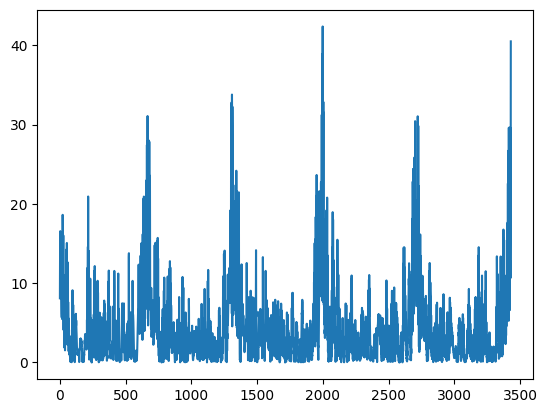

In [22]:
def curvature(points):
    """
    Compute the curvature κ of a discrete curve.
    
    Parameters:
        points (list of tuples/lists): [(x1,y1), (x2,y2), ...] or 3D points.
    
    Returns:
        numpy array: curvature values for each interior point
                     (first and last points have undefined curvature).
    """
    pts = np.asarray(points, dtype=float)
    
    # First derivative (velocity)
    r1 = np.gradient(pts, axis=0)

    # Second derivative (acceleration)
    r2 = np.gradient(r1, axis=0)
    
    if pts.shape[1] == 2:  
        # Pad to 3D so cross product works
        r1_3d = np.column_stack([r1, np.zeros(len(r1))])
        r2_3d = np.column_stack([r2, np.zeros(len(r2))])
    else:
        r1_3d, r2_3d = r1, r2

    # Curvature formula
    cross = np.cross(r1_3d, r2_3d)
    num = np.linalg.norm(cross, axis=1)
    den = np.linalg.norm(r1_3d, axis=1)**3
    
    kappa = np.zeros(len(points))
    valid = den > 0
    kappa[valid] = num[valid] / den[valid]

    return kappa

curvatures = curvature(contours_t.numpy())
#moving average of curvatures
window_size = 1
curvatures = np.convolve(curvatures, np.ones(window_size)/window_size, mode='same')
plt.plot(curvatures)


Text(0.5, 0, 'Contour Point Index')

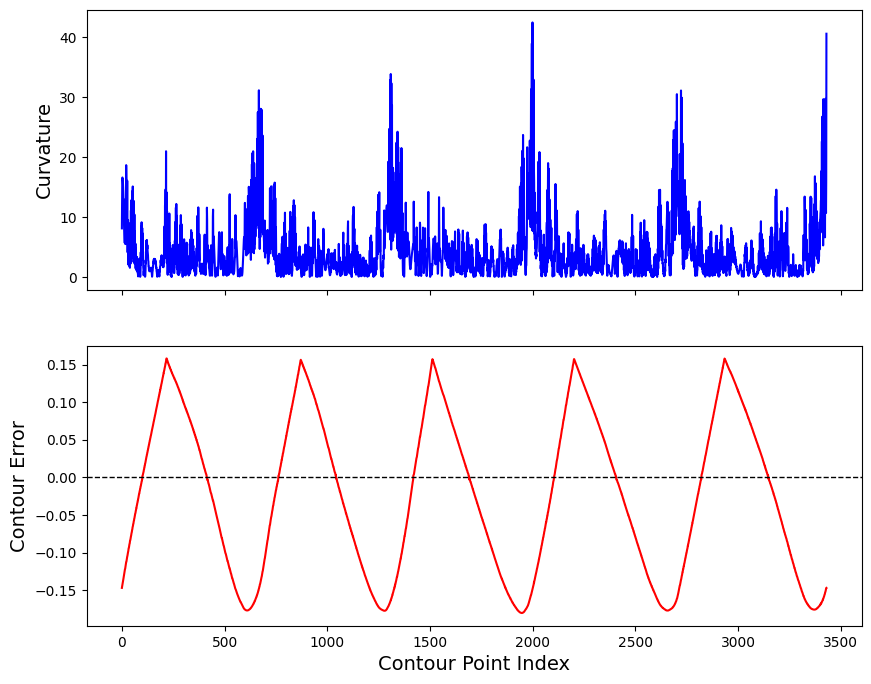

In [24]:
#plot curvature and contour error together below eachother
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
ax1.plot(curvatures, color='blue')
ax1.set_ylabel('Curvature', fontsize=14)
ax2.plot(contour_error.numpy(), color='red')
#also plot a horizontal line at y=0
ax2.axhline(0, color='black', linestyle='--', linewidth=1)
ax2.set_ylabel('Contour Error', fontsize=14)
ax2.set_xlabel('Contour Point Index', fontsize=14)


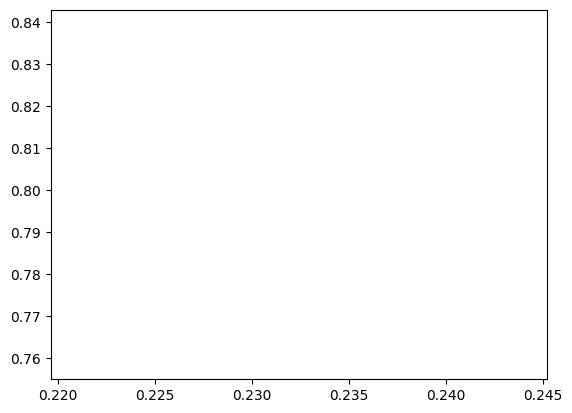

In [ ]:

Z_gt = bsp_geom.bspline_signed_distance_vectorized(pts_t, rounded_star_cp, degree=2).numpy().reshape(N, N)
contours_gt = measure.find_contours(Z_gt, level=0.0)
contours_gt = np.array(contours_gt).reshape(-1,2)
contours_gt = 2 * contours_gt/N - 1


In [ ]:
def find_closest_point_on_bspline_curve(query_point, control_points, degree=3,
                                       num_curve_samples=1000, device=None):
    """
    Find the parameter t on the B-spline curve closest to the query point.
    """
    if device is None:
        device = query_point.device
    query_point = query_point.to(device)
    control_points = control_points.to(device)
    # Create knot vector for closed curve
    knots = bsp_geom.create_knot_vector(control_points.shape[0], degree, closed=True).to(device)
    # Sample curve points
    t_values = torch.linspace(knots[degree], knots[-degree-1], num_curve_samples, device=device)
    curve_points = bsp_geom.evaluate_bspline_curve_vectorized(t_values, control_points, knots, degree, device)
    # Compute distances
    dists = torch.cdist(query_point, curve_points)  # (1, S)
    min_dists, min_indices = torch.min(dists, dim=1)
    return t_values[min_indices]

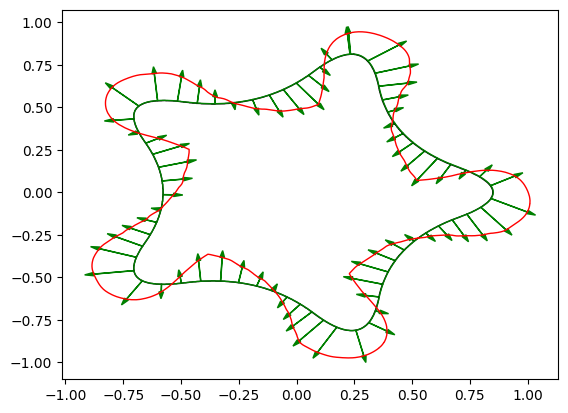

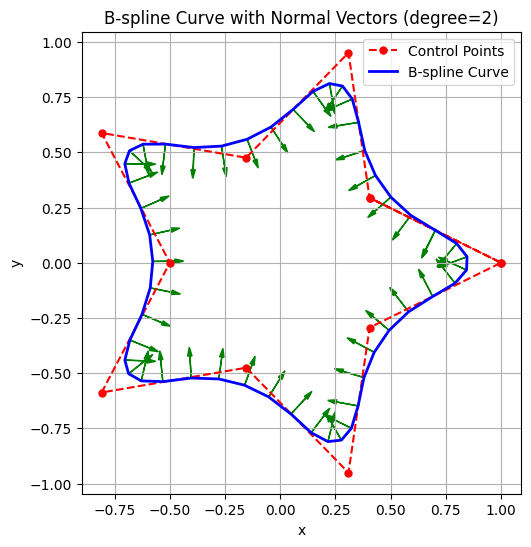

In [51]:
fig, ax = plt.subplots()
#ax.contourf(X, Y, Z, levels=50, cmap='RdBu_r')
magnitude = 1
ax.plot(contours_gt[:,1] , contours_gt[:,0] , 'k-',  linewidth=1)
#ax.plot(contours_t[:,1] , contours_t[:,0] , 'r-',  linewidth=1)

contours_t_altered_xy = torch.zeros_like(contours_t)
contours_t_altered_xy[:,0] = contours_t[:,1]
contours_t_altered_xy[:,1] = contours_t[:,0]

contours_gt_altered_xy = np.zeros_like(contours_gt)
contours_gt_altered_xy[:,0] = contours_gt[:,1]
contours_gt_altered_xy[:,1] = contours_gt[:,0]
#find t parameter for contour point
t = find_closest_point_on_bspline_curve(contours_t_altered_xy, rounded_star_cp, degree=2, num_curve_samples=10000)
normal_vec = bsp_geom.bspline_normalvectors(t=t, control_points=rounded_star_cp,knots=bsp_geom.create_knot_vector(rounded_star_cp.shape[0], 2, closed=True), degree=2)
new_point = np.zeros_like(contours_t.numpy())

tmp = bsp_geom.evaluate_bspline_curve_vectorized(t, rounded_star_cp, bsp_geom.create_knot_vector(rounded_star_cp.shape[0], 2, closed=True), 2)
ax.plot(tmp[:,0] , tmp[:,1] , 'g-',  linewidth=1)
for i in range(len(contours_t)):
    new_point[i] = tmp[i] + normal_vec[i].numpy()*magnitude*contour_error[i].numpy()
    if i % 50 == 0:
        start = tmp[i].numpy()
        err = contour_error[i].numpy()
        ax.arrow(start[0], start[1], normal_vec[i, 0].numpy()*err, normal_vec[i, 1].numpy()*err,
                  head_width=0.02, head_length=0.04, fc='g', ec='g')
ax.plot(new_point[:,0] , new_point[:,1] , 'r-',  linewidth=1)
geom_vis.plot_normal_vectors_on_bspline(rounded_star_cp, degree=2, num_vectors=50, vector_length=0.1)
    



plt.show()



In [55]:
print(contours_gt)

[[0.81128056 0.24804688]
 [0.8111793  0.24609375]
 [0.8111706  0.24414062]
 ...
 [0.81040705 0.25      ]
 [0.81054688 0.2497864 ]
 [0.81128056 0.24804688]]


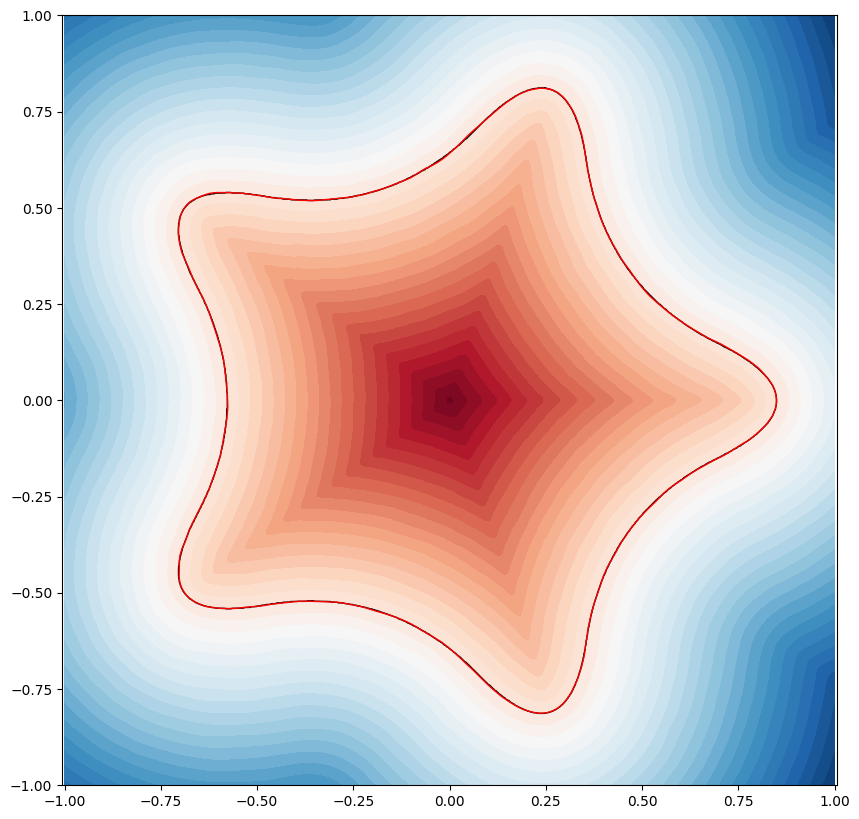

In [60]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.contourf(X, Y, Z, levels=50, cmap='RdBu_r')
plt.axis('equal')
ax.plot(contours_gt[:,1] , contours_gt[:,0] , 'k-', linewidth=1)
ax.plot(contours_t[:,1] , contours_t[:,0] , 'r-', linewidth=1)

plt.show()

In [ ]:
NI.plot_model_weight_per_layer_hyst(model)

In [8]:
def train_model_old(model,num_epochs=10):
    report_interval = num_epochs // 10
    criterion = nn.MSELoss()
    cntrl_pts = bsp_geom.create_polygon_bspline_control_points(5,degree=1)
    knots = bsp_geom.create_knot_vector(len(cntrl_pts), degree=1)
    for epoch in range(num_epochs):
        pts = torch.randn((500,2))*2-1
        #pts = pts.clone().detach().requires_grad_(True)
        pred = model(pts)
        target = bsp_geom.bspline_signed_distance_vectorized(pts,cntrl_pts,degree=1)
        loss_sdf = criterion(pred.squeeze(), target)
        loss = loss_sdf
        model.optimizer.zero_grad()
        loss.backward()
        model.optimizer.step()
        #model.lr_scheduler.step()
        model.loss_history.append(loss.item())
        if epoch % report_interval == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
train_model_old(model,100)

Epoch 0, Loss: 4.556866
Epoch 10, Loss: 3.761360
Epoch 20, Loss: 3.181367
Epoch 30, Loss: 2.467447
Epoch 40, Loss: 2.155694
Epoch 50, Loss: 2.265133
Epoch 60, Loss: 1.921426
Epoch 70, Loss: 1.436932
Epoch 80, Loss: 1.295657
Epoch 90, Loss: 1.372169
